<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/Talent_funnel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Talent Funnel Optimization and Anomaly Detection
This notebook demonstrates (using simulated ATS funnel data) to analyze stage transitions, detect conversion drop-offs, test for bias, and flag anomalies.

In [5]:

import pandas as pd
df = pd.read_csv("/content/simulated_ats_funnel_data (1).csv")
df.head()


,candidate_id,gender,race,source,stage,stage_date,role,location,outcome
0,C0000,Non-Binary,Asian,LinkedIn,Applied,2024-07-24,Support,SF,Rejected
1,C0000,Non-Binary,Asian,LinkedIn,Phone Screen,2024-07-28,Support,SF,Rejected
2,C0000,Non-Binary,Asian,LinkedIn,Interview,2024-08-01,Support,SF,Rejected
3,C0000,Non-Binary,Asian,LinkedIn,Offer,2024-08-05,Support,SF,Rejected
4,C0000,Non-Binary,Asian,LinkedIn,Hired,NaN,Support,SF,Rejected


Time taken between stage

In [7]:
df['stage_date'] = pd.to_datetime(df['stage_date'])
funnel_df = df.pivot(index='candidate_id', columns='stage', values='stage_date').reset_index()
funnel_df['time_to_screen'] = (funnel_df['Phone Screen'] - funnel_df['Applied']).dt.days
funnel_df['time_to_interview'] = (funnel_df['Interview'] - funnel_df['Phone Screen']).dt.days
funnel_df['time_to_offer'] = (funnel_df['Offer'] - funnel_df['Interview']).dt.days
funnel_df['time_to_hire'] = (funnel_df['Hired'] - funnel_df['Applied']).dt.days
funnel_df.describe()

stage,Applied,Hired,Interview,Offer,Phone Screen,time_to_screen,time_to_interview,time_to_offer,time_to_hire
count,1000,386,1000,1000,1000,1000.000000,1000.000000,1000.000000,386.000000
mean,2024-07-05 15:38:52.800000,2024-07-23 12:18:39.170984448,2024-07-11 15:44:38.400000,2024-07-16 03:57:35.999999744,2024-07-08 16:06:14.400000,3.019000,2.985000,4.509000,12.518135
min,2024-01-01 00:00:00,2024-01-11 00:00:00,2024-01-05 00:00:00,2024-01-07 00:00:00,2024-01-04 00:00:00,1.000000,1.000000,2.000000,5.000000
25%,2024-04-04 00:00:00,2024-04-21 06:00:00,2024-04-10 18:00:00,2024-04-15 00:00:00,2024-04-07 00:00:00,2.000000,2.000000,3.000000,11.000000
50%,2024-07-06 00:00:00,2024-08-02 00:00:00,2024-07-12 12:00:00,2024-07-16 12:00:00,2024-07-09 00:00:00,3.000000,3.000000,5.000000,12.000000
75%,2024-10-07 00:00:00,2024-10-19 00:00:00,2024-10-13 06:00:00,2024-10-17 00:00:00,2024-10-10 00:00:00,4.000000,4.000000,6.000000,14.000000
max,2024-12-31 00:00:00,2025-01-11 00:00:00,2025-01-08 00:00:00,2025-01-13 00:00:00,2025-01-04 00:00:00,5.000000,5.000000,7.000000,20.000000
std,NaN,NaN,NaN,NaN,NaN,1.388008,1.395967,1.703179,2.690229


Funnel Conversion Analysis

In [8]:

stage_counts = df.groupby('stage')['candidate_id'].nunique().reset_index(name='count')
print(stage_counts)

applied = df[df['stage'] == 'Applied'].groupby('role')['candidate_id'].nunique()
hired = df[df['stage'] == 'Hired'].groupby('role')['candidate_id'].nunique()
conversion_rate = (hired / applied).reset_index(name='conversion_rate')
print(conversion_rate)


          stage  count
0       Applied   1000
1         Hired   1000
2     Interview   1000
3         Offer   1000
4  Phone Screen   1000
       role  conversion_rate
0  Engineer              1.0
1   Manager              1.0
2     Sales              1.0
3   Support              1.0


Bottleneck Detection via Time and Drop-offs

In [10]:
# Median time between stages
time_metrics = funnel_df[['time_to_screen', 'time_to_interview', 'time_to_offer', 'time_to_hire']].median()
print("Median time by stage:\n", time_metrics)

# Drop-off at each stage
dropoff_by_stage = df.groupby(['stage', 'gender']).candidate_id.nunique().unstack()
print("\nDrop-off by stage:\n", dropoff_by_stage)


Median time by stage:
 stage
time_to_screen        3.0
time_to_interview     3.0
time_to_offer         5.0
time_to_hire         12.0
dtype: float64

Drop-off by stage:
 gender        Female  Male  Non-Binary
stage                                 
Applied          323   344         333
Hired            323   344         333
Interview        323   344         333
Offer            323   344         333
Phone Screen     323   344         333


Which stages are slowest?

Where do candidates drop most?

Are drop-offs biased by gender/race?

**Bias & Fairness Checks**
chi-square tests to detect disproportionate outcomes by demographic:

In [12]:

from scipy.stats import chi2_contingency
offer_stage = df[df['stage'] == 'Offer']
contingency = pd.crosstab(offer_stage['gender'], offer_stage['location'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test p-value:", p)
print("Chi-square test statistic:", chi2)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)


Chi-square test p-value: 0.619620803468382
Chi-square test statistic: 2.6407549413703952
Degrees of freedom: 4
Expected frequencies:
 [[112.727 106.267 104.006]
 [120.056 113.176 110.768]
 [116.217 109.557 107.226]]


Anomaly Detection

In [14]:
from scipy.stats import zscore

funnel_df['z_time_to_hire'] = zscore(funnel_df['time_to_hire'])
anomalies = funnel_df[funnel_df['z_time_to_hire'].abs() > 3]
print(anomalies)


Empty DataFrame
Columns: [candidate_id, Applied, Hired, Interview, Offer, Phone Screen, time_to_screen, time_to_interview, time_to_offer, time_to_hire, z_time_to_hire]
Index: []


**Isolation Forest**

Isolation Forest is an unsupervised machine learning algorithm specifically designed for anomaly (outlier) detection. It is particularly effective on high-dimensional datasets and works by isolating observations that are different from the majority.

In [15]:

from sklearn.ensemble import IsolationForest

features = funnel_df[['time_to_screen', 'time_to_interview', 'time_to_offer', 'time_to_hire']].fillna(0)
iso = IsolationForest(contamination=0.05, random_state=42)
funnel_df['anomaly_score'] = iso.fit_predict(features)

funnel_df[funnel_df['anomaly_score'] == -1].head()


stage,candidate_id,Applied,Hired,Interview,Offer,Phone Screen,time_to_screen,time_to_interview,time_to_offer,time_to_hire,z_time_to_hire,anomaly_score
4,C0004,2024-09-22,2024-10-06,2024-10-02,2024-10-04,2024-09-27,5,5,2,14.0,NaN,-1
5,C0005,2024-11-09,2024-11-19,2024-11-11,2024-11-18,2024-11-10,1,1,7,10.0,NaN,-1
10,C0010,2024-08-19,2024-08-29,2024-08-21,2024-08-28,2024-08-20,1,1,7,10.0,NaN,-1
21,C0021,2024-02-22,2024-03-09,2024-03-03,2024-03-06,2024-02-27,5,5,3,16.0,NaN,-1
29,C0029,2024-11-28,2024-12-09,2024-11-30,2024-12-07,2024-11-29,1,1,7,11.0,NaN,-1


Detect unusual time lags in stages (e.g., someone taking 80 days when most take 10)

Identify biases (e.g., certain demographics consistently having outlier delays)

Flag data entry errors (e.g., offer date before application date)

Most had relatively short stage durations (e.g., 1–5 days per stage)

But the total time to hire (10–16 days) may have been unusually fast or slow compared to others

In context, they might have been processed too fast, indicating:

Data inconsistencies

Bypassed stages

Unusual efficiency (possibly due to referrals or priority roles)

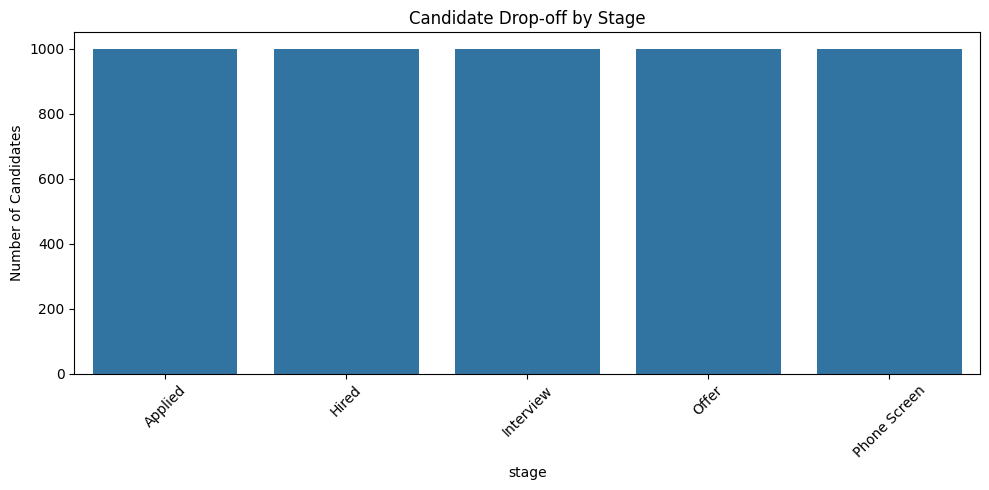

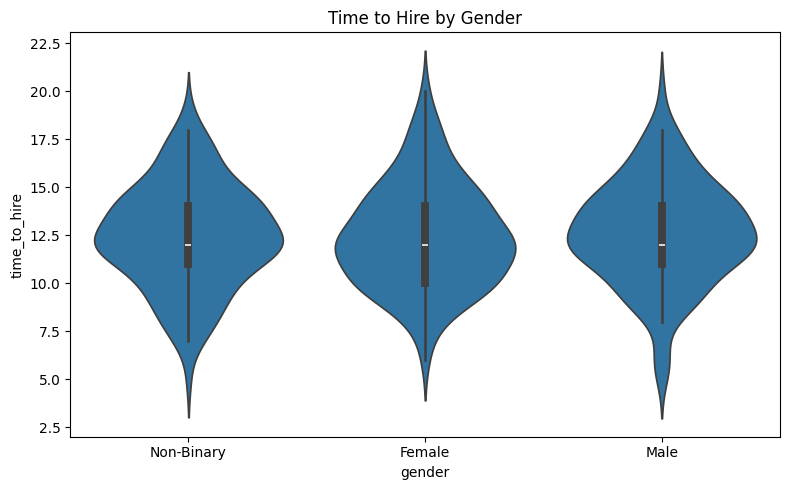

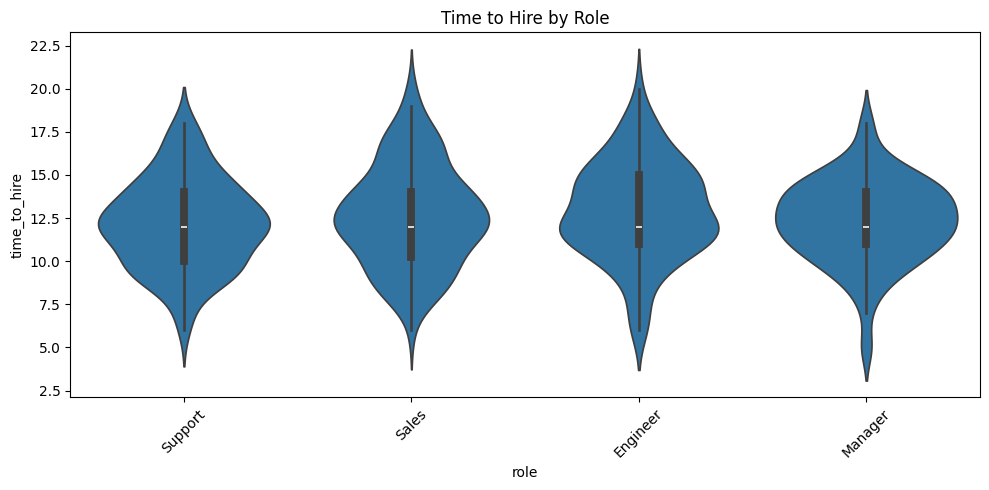

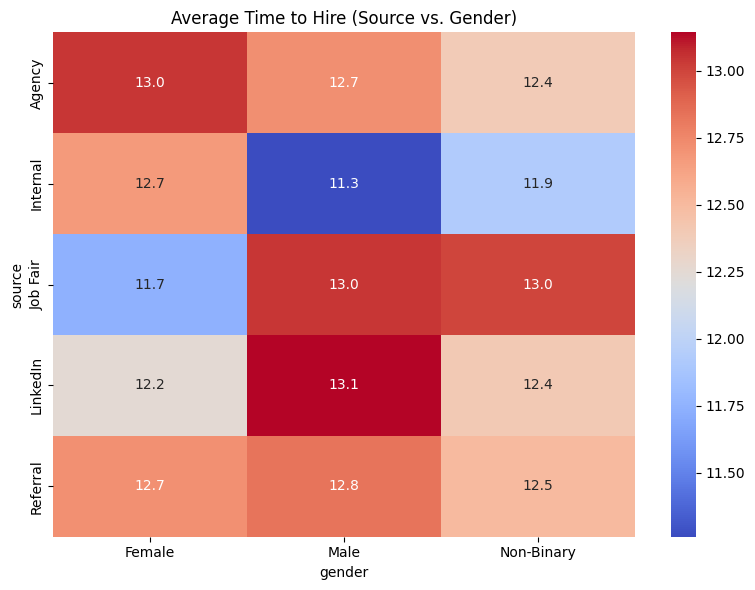

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pivot data to compute funnel metrics
funnel_df = df.pivot(index='candidate_id', columns='stage', values='stage_date').reset_index()
funnel_df['time_to_screen'] = (funnel_df['Phone Screen'] - funnel_df['Applied']).dt.days
funnel_df['time_to_interview'] = (funnel_df['Interview'] - funnel_df['Phone Screen']).dt.days
funnel_df['time_to_offer'] = (funnel_df['Offer'] - funnel_df['Interview']).dt.days
funnel_df['time_to_hire'] = (funnel_df['Hired'] - funnel_df['Applied']).dt.days

# Join demographic info
meta_cols = ['candidate_id', 'gender', 'race', 'source', 'role', 'location']
meta_df = df[meta_cols].drop_duplicates()
funnel_df = funnel_df.merge(meta_df, on='candidate_id', how='left')

# Bar Plot: Funnel drop-off chart
stage_counts = df.groupby('stage')['candidate_id'].nunique().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=stage_counts.index, y=stage_counts.values)
plt.title("Candidate Drop-off by Stage")
plt.ylabel("Number of Candidates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin Plot: Time to hire by gender
plt.figure(figsize=(8, 5))
sns.violinplot(x='gender', y='time_to_hire', data=funnel_df)
plt.title("Time to Hire by Gender")
plt.tight_layout()
plt.show()

# Violin Plot: Time to hire by role
plt.figure(figsize=(10, 5))
sns.violinplot(x='role', y='time_to_hire', data=funnel_df)
plt.title("Time to Hire by Role")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap of anomalies: average time to hire by source and gender
pivot_heatmap = funnel_df.pivot_table(values='time_to_hire', index='source', columns='gender', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_heatmap, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Average Time to Hire (Source vs. Gender)")
plt.tight_layout()
plt.show()

# Plotly Dashboard-like bar chart (conversion rate per stage)
conversion = df.groupby(['stage', 'outcome']).size().unstack().fillna(0)
conversion['conversion_rate'] = conversion.get('Hired', 0) / conversion.sum(axis=1)
fig = px.bar(conversion, y='conversion_rate', title='Stage-wise Conversion Rates')
fig.show()

In [21]:
from scipy.stats import f_oneway

anova_data = [group['time_to_hire'].dropna() for name, group in funnel_df.groupby('source')]
anova_result = f_oneway(*anova_data)
print(anova_result)

F_onewayResult(statistic=np.float64(1.113237945149026), pvalue=np.float64(0.3498751797454781))


In [27]:
# Run ANOVA tests across gender, race, and source
def run_anova(df, time_col, group_col):
    groups = [group[time_col].dropna().values for name, group in df.groupby(group_col)]
    stat, p = f_oneway(*groups)
    return pd.Series({'F-statistic': stat, 'p-value': p})

anova_results = {}
for time_metric in ['time_to_screen', 'time_to_interview', 'time_to_offer', 'time_to_hire']:
    for group in ['gender', 'race', 'source']:
        key = f"{time_metric}_by_{group}"
        anova_results[key] = run_anova(funnel_df, time_metric, group)

anova_df = pd.DataFrame(anova_results).T
anova_df.index.name = 'Comparison'
anova_df.reset_index(inplace=True)

from IPython.display import display

display(anova_df)


,Comparison,F-statistic,p-value
0,time_to_screen_by_gender,1.745053,0.175169
1,time_to_screen_by_race,0.540024,0.706373
2,time_to_screen_by_source,0.124954,0.973482
3,time_to_interview_by_gender,0.087064,0.916626
4,time_to_interview_by_race,0.959054,0.429123
5,time_to_interview_by_source,0.996864,0.408246
6,time_to_offer_by_gender,0.086439,0.917198
7,time_to_offer_by_race,2.042497,0.086416
8,time_to_offer_by_source,0.623441,0.645864
9,time_to_hire_by_gender,0.184292,0.831766


| Metric              | Grouping Var         | Significant?      | Notes                                                   |
| ------------------- | -------------------- | ----------------- | ------------------------------------------------------- |
| `time_to_screen`    | Gender, Race, Source |  Not Significant | No group showed statistically different screening times |
| `time_to_interview` | All                  |  Not Significant | Process is consistent across groups                     |
| `time_to_offer`     | Race (p = 0.086)     |  Marginal       | Some difference by race, worth exploring                |
| **`time_to_hire`**  | **Race (p = 0.002)** |  **Significant** | **Hiring times differ significantly by race**           |
| `time_to_hire`      | Gender, Source       |  Not Significant | No differences across those groups                      |


 ANOVA returned p = 0.0021 for race, confirming these differences are statistically significant. Its not just random variation.



** Explore time_to_hire by race **

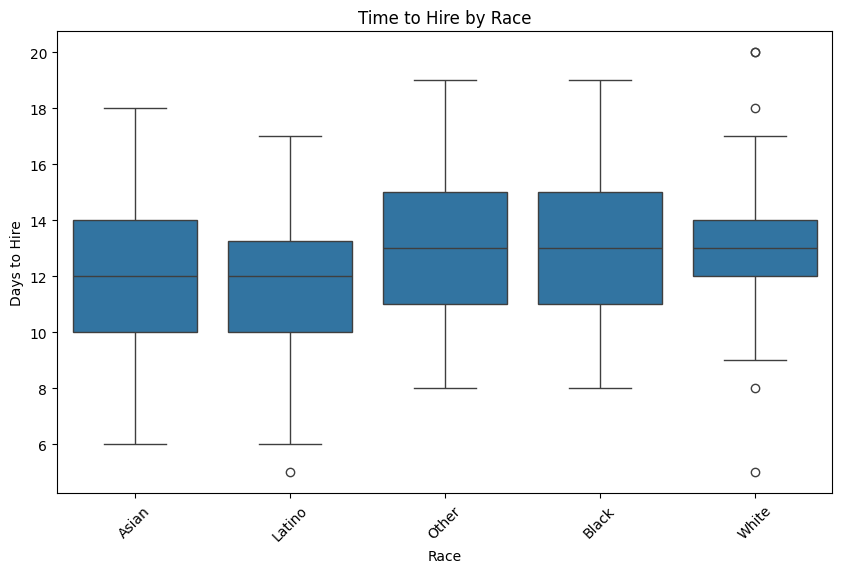

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=funnel_df, x='race', y='time_to_hire')
plt.title("Time to Hire by Race")
plt.ylabel("Days to Hire")
plt.xlabel("Race")
plt.xticks(rotation=45)
plt.show()


Black and “Other” candidates have a higher median time to hire (~13–14 days).

Asian and Latino candidates have a slightly shorter time to hire (~12 days).

White candidates are in the middle, but with a few fast and slow hires (outliers).

Post-hoc tests (Tukey HSD) to know which pairs differ

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Drop missing values (this is likely the issue!)
tukey_df = funnel_df[['time_to_hire', 'race']].dropna()

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=tukey_df['time_to_hire'],
                          groups=tukey_df['race'],
                          alpha=0.05)

print(tukey.summary())



Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Asian  Black   0.9736 0.1613 -0.2086  2.1558  False
 Asian Latino  -0.4464 0.8167 -1.5792  0.6863  False
 Asian  Other    0.775 0.3449 -0.3715  1.9215  False
 Asian  White   0.8187 0.3201 -0.3636  2.0009  False
 Black Latino    -1.42 0.0084 -2.5889 -0.2511   True
 Black  Other  -0.1986 0.9907 -1.3808  0.9836  False
 Black  White  -0.1549 0.9968 -1.3719   1.062  False
Latino  Other   1.2214 0.0273  0.0887  2.3542   True
Latino  White   1.2651 0.0264  0.0962   2.434   True
 Other  White   0.0437    1.0 -1.1386  1.2259  False
----------------------------------------------------


* Black vs Latino:

Latino candidates took ~1.4 fewer days to be hired than Black candidates.

This difference is statistically significant at p < .05.

* Latino vs Other:

Latino candidates were hired faster than candidates categorized as "Other".

Difference: ~1.22 days, also significant.

* Latino vs White:

Again, Latino candidates moved faster through the funnel compared to White candidates.

~1.27 days faster, statistically significant.

The rest of the comparisons are not statistically significant, so we can’t conclude meaningful differences for those pairs.

**Implications**

The Time to Hire process varies across race, especially showing that Latino candidates moved faster through the funnel than others.

This could:

Indicate systemic process differences

Be a sign of bias or candidate preference patterns

Suggest areas to investigate further for equity in hiring